### This issue highlights the importance of understanding how range() works in Python - range(n) generates numbers from 0 to n-1, not 1 to n.
### So when you change to using the variable store as the store number, you're actually looking for a store with number 0, not 1. If there's no store with number 0 in your monthly_metrics DataFrame, the filtered DataFrame will be empty, causing issues

len(Data_frame)   shows the number of rows in the data frame

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
from scipy.stats import pearsonr, ttest_ind
from sklearn.preprocessing import MinMaxScaler


In [40]:
mdata = pd.read_csv("mdata.csv")

In [41]:
mdata

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,natural chips compny seasalt175g,2,6.0,175.0,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,ccs nacho cheese 175g,3,6.3,175.0,CCS,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,smiths crinkle cut chips chicken 170g,2,2.9,170.0,SMITHS,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,smiths chips thinly s/cream&onion 175g,5,15.0,175.0,SMITHS,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,kettle tortilla chpshny&jlpno chili 150g,3,13.8,150.0,KETTLE,MIDAGE SINGLES/COUPLES,Budget
...,...,...,...,...,...,...,...,...,...,...,...,...
246735,2019-03-09,272,272319,270088,89,kettle sweet chilli and sour cream 175g,2,10.8,175.0,KETTLE,YOUNG SINGLES/COUPLES,Premium
246736,2018-08-13,272,272358,270154,74,tostitos splash of lime 175g,1,4.4,175.0,TOSTITOS,YOUNG SINGLES/COUPLES,Premium
246737,2018-11-06,272,272379,270187,51,doritos mexicana 170g,2,8.8,170.0,DORITOS,YOUNG SINGLES/COUPLES,Premium
246738,2018-12-27,272,272379,270188,42,doritos corn chips mexican jalapeno 150g,2,7.8,150.0,DORITOS,YOUNG SINGLES/COUPLES,Premium


In [42]:
mdata['DATE'] = pd.to_datetime(mdata['DATE'])
mdata['MONTH']=mdata['DATE'].dt.month

##### Selecting control stores

The client has selected store numbers 77, 86 and 88 as trial stores and want control stores to be established
stores that are operational for the entire observation period.

We would want to match trial stores to control stores that are similar to the trial store prior to the trial period (FEB, MAR, APR 2019): 
- Monthly overall sales revenue
- Monthly number of customers
- Monthly number of transactions per customer

Let’s first create the metrics of interest and filter to stores that are present throughout the pre-trial period

In [43]:
monthly_metrics = mdata.groupby(['STORE_NBR', 'MONTH']).agg(
    total_sales=('TOT_SALES', 'sum'),
    total_customers=('LYLTY_CARD_NBR', lambda x: x.nunique()),
    transactions_per_customer=('LYLTY_CARD_NBR', lambda x: x.count()/x.nunique())
).reset_index()



In [44]:
MONTH_ORDER = {7: 1, 8: 2, 9: 3, 10: 4, 11: 5, 12: 6, 1: 7, 2: 8, 3: 9, 4: 10, 5: 11, 6: 12}
monthly_metrics['MONTH_ORDER'] = monthly_metrics['MONTH'].map(MONTH_ORDER)
monthly_metrics = monthly_metrics.sort_values(['STORE_NBR', 'MONTH_ORDER'])
# monthly_metrics = monthly_metrics.drop(columns=['MONTH_ORDER'])
monthly_metrics = monthly_metrics.reset_index(drop=True)

In [45]:
monthly_metrics

,STORE_NBR,MONTH,total_sales,total_customers,transactions_per_customer,MONTH_ORDER
0,1,7,188.9,47,1.042553,1
1,1,8,168.4,41,1.000000,2
2,1,9,268.1,57,1.035088,3
3,1,10,175.4,39,1.025641,4
4,1,11,184.8,44,1.022727,5
...,...,...,...,...,...,...
3160,272,2,385.3,44,1.068182,8
3161,272,3,421.9,48,1.062500,9
3162,272,4,445.1,54,1.037037,10
3163,272,5,314.6,34,1.176471,11


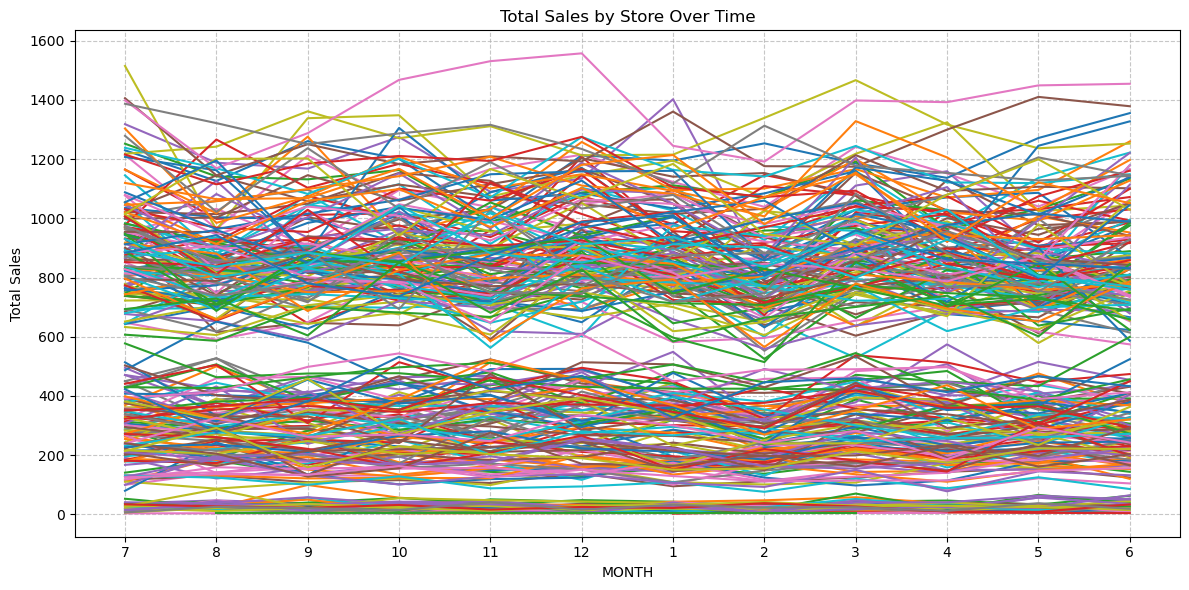

In [46]:
plt.figure(figsize=(12, 6))  # Create a larger figure for better visibility

for i in range(monthly_metrics['STORE_NBR'].nunique()):
    # Filter the data for the current store and save it to a variable
    store_data = monthly_metrics[monthly_metrics['STORE_NBR'] == i]
    
    # Plot the total sales for this store
    # This assumes monthly_metrics has a datetime index or a column representing months
    plt.plot(store_data['MONTH_ORDER'], store_data['total_sales'], label=f'Store {i}')
    plt.xticks(store_data['MONTH_ORDER'], store_data['MONTH'])

plt.title('Total Sales by Store Over Time')
plt.xlabel('MONTH')
plt.ylabel('Total Sales')
plt.tight_layout()  # Adjust layout to make room for the legend
plt.grid(True, linestyle='--', alpha=0.7)  # Add grid for better readability
plt.show()

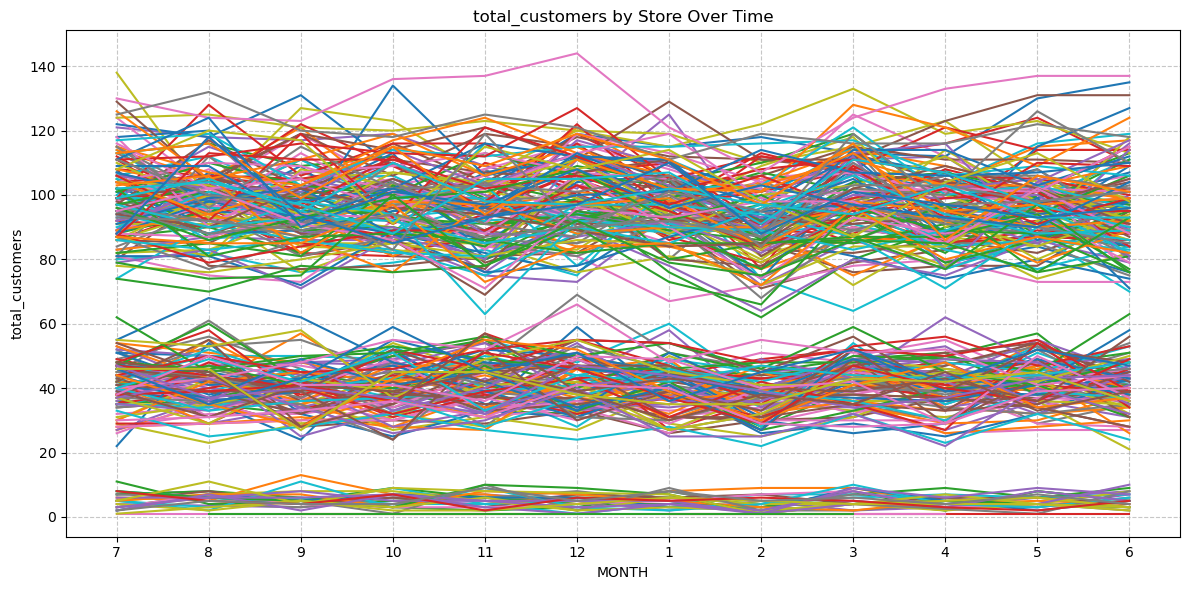

In [47]:
plt.figure(figsize=(12, 6))  # Create a larger figure for better visibility

for i in range(monthly_metrics['STORE_NBR'].nunique()):
    # Filter the data for the current store and save it to a variable
    store_data = monthly_metrics[monthly_metrics['STORE_NBR'] == i]
    
    # Plot the total sales for this store
    # This assumes monthly_metrics has a datetime index or a column representing months
    plt.plot(store_data['MONTH_ORDER'], store_data['total_customers'], label=f'Store {i}')
    plt.xticks(store_data['MONTH_ORDER'], store_data['MONTH'])

plt.title('total_customers by Store Over Time')
plt.xlabel('MONTH')
plt.ylabel('total_customers')
plt.tight_layout()  # Adjust layout to make room for the legend
plt.grid(True, linestyle='--', alpha=0.7)  # Add grid for better readability
plt.show()

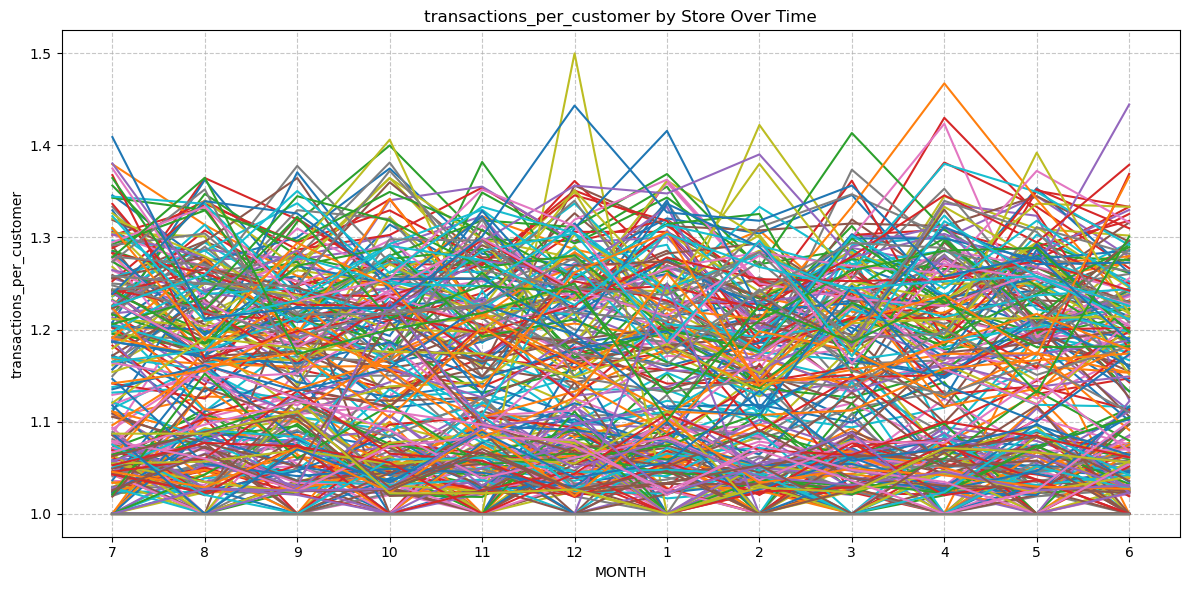

In [48]:
plt.figure(figsize=(12, 6))  # Create a larger figure for better visibility

for i in range(monthly_metrics['STORE_NBR'].nunique()):
    # Filter the data for the current store and save it to a variable
    store_data = monthly_metrics[monthly_metrics['STORE_NBR'] == i]
    
    # Plot the total sales for this store
    # This assumes monthly_metrics has a datetime index or a column representing months
    plt.plot(store_data['MONTH_ORDER'], store_data['transactions_per_customer'], label=f'Store {i}')
    plt.xticks(store_data['MONTH_ORDER'], store_data['MONTH'])

plt.title('transactions_per_customer by Store Over Time')
plt.xlabel('MONTH')
plt.ylabel('transactions_per_customer')
plt.tight_layout()  # Adjust layout to make room for the legend
plt.grid(True, linestyle='--', alpha=0.7)  # Add grid for better readability
plt.show()

In [49]:
 def calculate_similarity(trial_store, metric_df):   
    trial_metrics = metric_df[metric_df['STORE_NBR'] == trial_store].sort_values('MONTH')

    control_scores = []
    for store in metric_df['STORE_NBR'].unique():
        if store == trial_store:
            continue
        
        control_metrics = monthly_metrics[monthly_metrics['STORE_NBR'] == store].sort_values('MONTH')
        if len(control_metrics) < 12: # filter to reach stores that are operational for the entire observation period.
            continue

        # if len(merged) < 2:    this filter is not needed because we already filtered out stores that are operational for the entire observation period.
            # continue

        metrics = ['total_sales', 'total_customers']
        merged = pd.merge(trial_metrics, control_metrics, on='MONTH', suffixes=('_trial', '_control'))
        merged = merged[merged['MONTH'].isin([7,8,9,10,11,12,1,2])]
        scores = []

        for metric in metrics:    
            corr, _ = pearsonr(merged[f'{metric}_trial'], merged[f'{metric}_control'])
            diff = abs(merged[f'{metric}_trial'] - merged[f'{metric}_control'])
            mag = 1 - (diff - diff.min()) / (diff.max() - diff.min())
            mag_score = mag.mean()
            scores.append((corr + mag_score) / 2)
        if  np.isnan(scores).any():
            final_score = 0
        else:
            final_score = np.mean(scores)
        control_scores.append((store, final_score))

    best_match = sorted(control_scores, key=lambda x: x[1], reverse=True)[0]
    return best_match

the code bellow is just inside of the function above for testing the results:

In [50]:
trial_metrics = monthly_metrics[monthly_metrics['STORE_NBR'] == 77].sort_values('MONTH')

control_scores = []
for store in monthly_metrics['STORE_NBR'].unique():
    if store == 86:
        continue

    control_metrics = monthly_metrics[monthly_metrics['STORE_NBR'] == store].sort_values('MONTH')
    if len(control_metrics) < 12: # filter to reach stores that are operational for the entire observation period.
        continue

    # if len(merged) < 2:    this filter is not needed because we already filtered out stores that are operational for the entire observation period.
    #     continue
    
    metrics = ['total_sales', 'total_customers']
    merged = pd.merge(trial_metrics, control_metrics, on='MONTH', suffixes=('_trial', '_control'))
    merged = merged[merged['MONTH'].isin([7,8,9,10,11,12,1,2])]
    scores = []
    
    for metric in metrics:    
        corr, _ = pearsonr(merged[f'{metric}_trial'], merged[f'{metric}_control'])
        diff = abs(merged[f'{metric}_trial'] - merged[f'{metric}_control'])
        mag = 1 - (diff - diff.min()) / (diff.max() - diff.min())
        mag_score = mag.mean()
        scores.append((corr + mag_score) / 2)
    if  np.isnan(scores).any():
        final_score = 0
    else:
        final_score = np.mean(scores)
    control_scores.append((store, final_score))

best_match = sorted(control_scores, key=lambda x: x[1], reverse=True)
best_match

[(233, 0.8164366507135801),
 (162, 0.6942045864229106),
 (50, 0.662320581913866),
 (35, 0.6466104841482337),
 (27, 0.6377531135421897),
 (254, 0.6357743597775529),
 (157, 0.6239925545993077),
 (71, 0.6205865994122797),
 (119, 0.6175852167857676),
 (167, 0.6128637383148162),
 (53, 0.6051419313200619),
 (237, 0.602119088564639),
 (250, 0.5959575556032155),
 (17, 0.5912162560044639),
 (257, 0.5807497074945202),
 (30, 0.5691424132346359),
 (105, 0.5676707530750863),
 (178, 0.56631191469697),
 (69, 0.5655401953890982),
 (265, 0.5644965164037146),
 (115, 0.5619670460839694),
 (234, 0.556377845135915),
 (60, 0.5554430160968612),
 (248, 0.5322495505348586),
 (37, 0.5289101232222588),
 (3, 0.5273693178888263),
 (195, 0.523247321349593),
 (84, 0.5056785705173346),
 (14, 0.5022734721110761),
 (113, 0.5008236165175184),
 (188, 0.5002207140830148),
 (64, 0.4940959123883838),
 (121, 0.49129708185775334),
 (81, 0.4861183707891505),
 (57, 0.4825036510178634),
 (10, 0.48106079000133706),
 (96, 0.473124

In [51]:

for store in monthly_metrics['STORE_NBR'].unique():
    control_metrics = monthly_metrics[monthly_metrics['STORE_NBR'] == store].sort_values('MONTH')
    if len(control_metrics) < 12:
        print ([store, len(control_metrics)]);


[11, 2]
[31, 2]
[44, 11]
[76, 1]
[85, 1]
[92, 1]
[117, 10]
[177, 11]
[193, 3]
[206, 2]
[218, 11]
[252, 2]


In [52]:
trial_stores = [77, 86, 88]
control_matches = {}

for trial in trial_stores:
    control, score = calculate_similarity(trial, monthly_metrics)
    control_matches[trial] = control

control_matches


{77: 233, 86: 155, 88: 237}

In [53]:
trial_period = [2, 3, 4]

for trial in trial_stores:
    control = control_matches[trial]

    trial_data = monthly_metrics[(monthly_metrics['STORE_NBR'] == trial) & 
                                 (monthly_metrics['MONTH'].isin(trial_period))]
    
    control_data = monthly_metrics[(monthly_metrics['STORE_NBR'] == control) & 
                                   (monthly_metrics['MONTH'].isin(trial_period))]

    # Compare total sales
    t_stat, p_val = ttest_ind(trial_data['total_sales'], control_data['total_sales'])

    print(f"Trial Store {trial} vs Control Store {control}")
    print(f"  T-Stat: {t_stat:.2f}, P-Value: {p_val:.4f}")
    print(f"  Trial Mean: {trial_data['total_sales'].mean():.2f}, Control Mean: {control_data['total_sales'].mean():.2f}")
    print("---")


Trial Store 77 vs Control Store 233
  T-Stat: 2.24, P-Value: 0.0889
  Trial Mean: 241.60, Control Mean: 181.83
---
Trial Store 86 vs Control Store 155
  T-Stat: 1.43, P-Value: 0.2258
  Trial Mean: 874.07, Control Mean: 806.07
---
Trial Store 88 vs Control Store 237
  T-Stat: 2.35, P-Value: 0.0789
  Trial Mean: 1374.53, Control Mean: 1214.73
---


In [57]:
trial_period = [2, 3, 4]

trial_data = monthly_metrics[(monthly_metrics['STORE_NBR'] == 77) & 
                                 (monthly_metrics['MONTH'].isin(trial_period))]
    
control_data = monthly_metrics[(monthly_metrics['STORE_NBR'] == 233) & 
                                   (monthly_metrics['MONTH'].isin(trial_period))]

merged = pd.merge(trial_data, control_data, on='MONTH', suffixes=('_trial', '_control'))

merged



,STORE_NBR_trial,MONTH,total_sales_trial,total_customers_trial,transactions_per_customer_trial,MONTH_ORDER_trial,STORE_NBR_control,total_sales_control,total_customers_control,transactions_per_customer_control,MONTH_ORDER_control
0,77,2,211.6,40,1.000000,8,233,220.7,42,1.023810,8
1,77,3,255.1,46,1.108696,9,233,180.6,35,1.028571,9
2,77,4,258.1,47,1.000000,10,233,144.2,27,1.074074,10


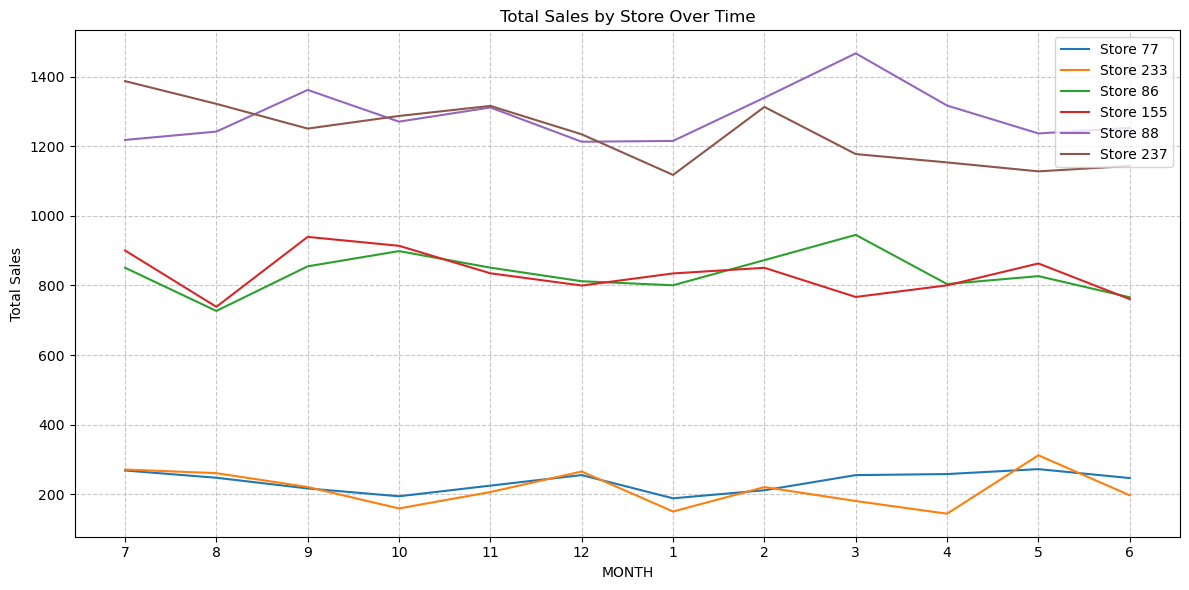

In [55]:
plt.figure(figsize=(12, 6))  # Create a larger figure for better visibility

for i in [77, 233, 86, 155, 88, 237]:
    # Filter the data for the current store and save it to a variable
    store_data = monthly_metrics[monthly_metrics['STORE_NBR'] == i]
    plt.plot(store_data['MONTH_ORDER'], store_data['total_sales'], label=f'Store {i}')
    plt.xticks(store_data['MONTH_ORDER'], store_data['MONTH'])

plt.title('Total Sales by Store Over Time')
plt.xlabel('MONTH')
plt.ylabel('Total Sales')
plt.legend()
plt.tight_layout()  # Adjust layout to make room for the legend
plt.grid(True, linestyle='--', alpha=0.7)  # Add grid for better readability
plt.show()